In [1]:
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, plot_roc_curve, roc_curve
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Wrangle


In [2]:
# Pick target
target = 'USE1'

# Load construct dictionary
constructs=pd.read_csv('data/construct_measures.csv', index_col='variable')

# Display the target 
print(target,'-', constructs.loc[target].statement)

USE1 - I use Wikipedia to develop my teaching materials


In [3]:
def wrangle(df):
    df = df.copy()
    
    # Remap target to binary and drop neutral (3.0) values and null values
    df[target] = df[target].map({5:'Yes', 4: 'Yes', 2: 'No', 1: 'No'})
    df = df.dropna(subset=[target])

    return df.reset_index().drop(columns='index')

# Load and wrangle training data
df = wrangle(pd.read_csv('data/wiki4HE_train.csv',index_col=0))

In [4]:
df.sample(10)

,AGE,GENDER,DOMAIN,PHD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,...,BI2,INC1,INC2,INC3,INC4,EXP1,EXP2,EXP3,EXP4,EXP5
394,41,1,1.0,0,6.0,1,6.0,2.0,NaN,0.0,...,2.0,4.0,3.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0
322,46,1,4.0,0,15.0,1,6.0,2.0,NaN,0.0,...,2.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0,1.0,4.0
73,40,1,1.0,1,5.0,1,3.0,NaN,NaN,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,2.0
437,39,1,5.0,0,16.0,1,6.0,2.0,NaN,0.0,...,3.0,4.0,3.0,5.0,5.0,1.0,2.0,2.0,1.0,1.0
461,35,1,6.0,0,4.0,1,6.0,1.0,6.0,0.0,...,4.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,2.0,3.0
235,60,0,6.0,0,7.0,1,6.0,2.0,NaN,0.0,...,4.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0
27,46,0,6.0,1,18.0,1,3.0,NaN,NaN,0.0,...,2.0,4.0,3.0,4.0,4.0,2.0,2.0,4.0,1.0,3.0
252,34,0,4.0,0,11.0,1,6.0,2.0,NaN,0.0,...,3.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,2.0
429,38,1,1.0,0,1.0,1,6.0,2.0,NaN,0.0,...,3.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,1.0,5.0
380,45,1,1.0,0,15.0,1,6.0,2.0,NaN,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,4.0,1.0,1.0,2.0


# Split Data

In [5]:
y = df[target]
X = df.drop(columns=df.loc[:,'USE1':'USE5'].columns)

Our model is going to use cross validation so we won't need to utilize a train-validate split.e

# Baseline Metrics

In [6]:
print('Baseline Accuracy:', y.value_counts(normalize=True).max())

Baseline Accuracy: 0.8391608391608392


# Build Base Model

In [7]:
model = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    LogisticRegression()
)

# Check Metrics

In [8]:
cv_scores = cross_val_score(model, X, y, cv=5)
print('Cross Validation Score LogisticRegression')
print(cv_scores)
print('Mean CV accuracy score:', cv_scores.mean())
print('STD CV accuracy score:', cv_scores.std())

Cross Validation Score LogisticRegression
[0.68695652 0.84347826 0.88596491 0.92105263 0.90350877]
Mean CV accuracy score: 0.8481922196796339
STD CV accuracy score: 0.08463392768783065


# Tune Model


In [9]:
params = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': np.arange(0.1, 3, 0.1)
}

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid=params,
    scoring='roc_auc',
    cv=cross_validation
)


In [10]:
grid_search.fit(X,y)
y_pr = grid_search.decision_function(X)
roc_auc_score(y, y_pr)

0.9758605072463767

In [11]:
model.named_steps['logisticregression'].get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [12]:
grid_search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__simpleimputer', 'estimator__logisticregression', 'estimator__simpleimputer__add_indicator', 'estimator__simpleimputer__copy', 'estimator__simpleimputer__fill_value', 'estimator__simpleimputer__missing_values', 'estimator__simpleimputer__strategy', 'estimator__simpleimputer__verbose', 'estimator__logisticregression__C', 'estimator__logisticregression__class_weight', 'estimator__logisticregression__dual', 'estimator__logisticregression__fit_intercept', 'estimator__logisticregression__intercept_scaling', 'estimator__logisticregression__l1_ratio', 'estimator__logisticregression__max_iter', 'estimator__logisticregression__multi_class', 'estimator__logisticregression__n_jobs', 'estimator__logisticregression__penalty', 'estimator__logisticregression__random_state', 'estimator__logisticregression__solver', 'estimator__logisticregression__tol', 'estimator__logisticregression__verbose', 'es

# Communicate Results

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

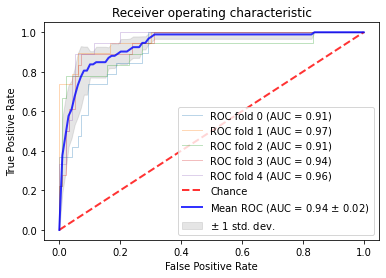

In [14]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
classifier = clone(model)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cross_validation.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

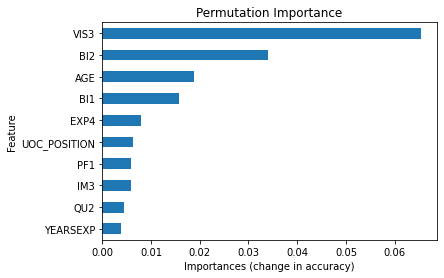

In [119]:
# Permutation importance
perm_imp = permutation_importance(estimator=model, X=X, y=y, random_state=42)

data = {
    'importances_mean': perm_imp['importances_mean'],
    'importances_std': perm_imp['importances_std']
}
pi_df = pd.DataFrame(data, index=X.columns).sort_values(by='importances_mean')

pi_df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importances (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation Importance');

In [149]:
for i in range(10):
    feature = pi_df.tail(10).index[i]
    print(feature, '-', constructs.loc[feature].statement)

YEARSEXP - Years of university teaching experience
QU2 - Articles in Wikipedia are updated
IM3 - My colleagues use Wikipedia
PF1 - I contribute to blogs
UOC_POSITION - Professor; Associate; Assistant; Lecturer; Instructor; Adjunct
EXP4 - I contribute to Wikipedia (editions, revisions, articles improvement...)
BI1 - In the future I will recommend the use of Wikipedia to my colleagues and students
AGE - Age of Professor
BI2 - In the future I will use Wikipedia in my teaching activity
VIS3 - I cite Wikipedia in my academic papers
